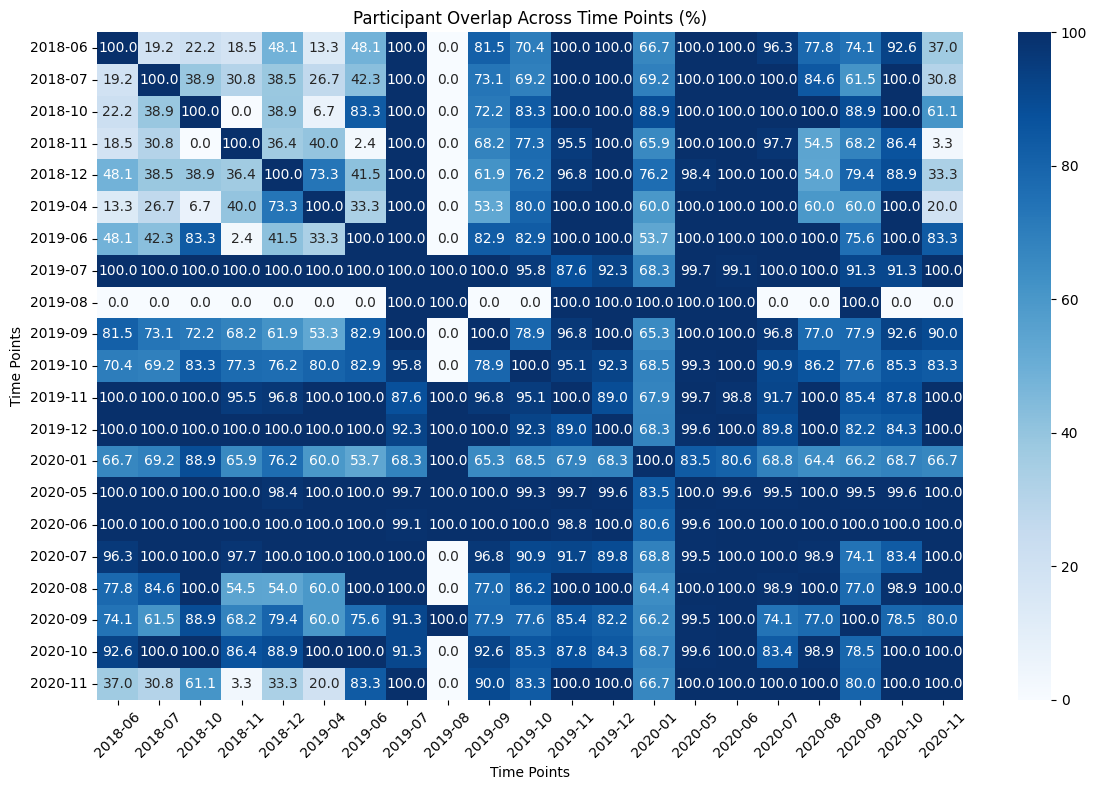

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"Study2_data_standardized.csv")

# Create a dictionary of unique participants for each time point
participant_dict = df.groupby('YearMonth')['Participant_Number'].apply(set).to_dict()

# Initialize an empty DataFrame to store pairwise overlap percentages
time_points = list(participant_dict.keys())
overlap_matrix = pd.DataFrame(index=time_points, columns=time_points)

# Compute pairwise overlaps
for t1 in time_points:
    for t2 in time_points:
        overlap_count = len(participant_dict[t1].intersection(participant_dict[t2]))
        min_count = min(len(participant_dict[t1]), len(participant_dict[t2]))
        overlap_percentage = (overlap_count / min_count) * 100 if min_count > 0 else 0
        overlap_matrix.loc[t1, t2] = overlap_percentage

# Convert overlap matrix to numeric for plotting
overlap_matrix = overlap_matrix.astype(float)

# Visualize the overlap matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(overlap_matrix, annot=True, fmt=".1f", cmap="Blues", cbar=True)
plt.title("Participant Overlap Across Time Points (%)")
plt.xlabel("Time Points")
plt.ylabel("Time Points")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Dynamic Network Subset



Selection Method:
You included participants who responded during at least 60% of the total time points.
This method ensures that you capture long-term patterns by keeping participants who have been reasonably consistent throughout the entire study period.

Goal:
This approach is better for exploring long-term trends and causal relationships across a broad range of time points.


Strengths:
- Retains a larger number of time points, making it suitable for analyses like:
- Granger causality across a long time span.
- Dynamic network analysis, where you track how relationships between variables change over time.
- Allows you to investigate temporal trends across multiple phases of participant responses.

Limitations:
- Some participants may have missing data for specific months, making it less ideal for cross-lagged panel models (CLPM), which require complete data for each time point.


In [ ]:
# Set threshold for at least 50% of total time points
threshold_dynamic = 0.55 * len(time_points)  # A little more than half of total time points

# Count valid time points for each participant
valid_time_points = df.groupby('Participant_Number')['YearMonth'].nunique()

# Filter participants who meet the threshold
consistent_participants_dynamic = valid_time_points[valid_time_points >= threshold_dynamic].index

# Subset the dataset
df_dynamic_subset = df[df['Participant_Number'].isin(consistent_participants_dynamic)]

df_dynamic_subset.to_csv(r"granger_data.csv", index=False)

df_dynamic_subset


# Cross-Lagged Panel Model Subset

cluster_1 = ['2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06']
cluster_2 = ['2020-07', '2020-08', '2020-09', '2020-10', '2020-11']

Selection Method:
Manually selected a specific cluster of consecutive months (['2020-07', '2020-08', '2020-09', '2020-10']).
Filtered participants who had data for all selected months (i.e., no missing time points for any participant).

Goal:
This approach is designed for CLPM, which requires complete data across consecutive time points for accurate estimation of within-person and between-person effects.

Strengths:
- Ensures that no missing data exists for the selected participants across the specified time points, making it ideal for:
 - CLPM or RI-CLPM, which require balanced panels (i.e., all participants measured at all time points).
- Focuses on a specific time period, allowing you to capture short-term directional effects within that window.

Limitations:
By focusing on a specific set of months, you lose information about longer-term trends and may exclude participants who were otherwise consistent but didn’t respond during these exact months.


In [26]:
df = pd.read_csv(r"Study2_data_standardized.csv")
df['YearMonth'] = pd.to_datetime(df['YearMonth']).dt.to_period('M')

# Define the cluster with the highest consistency
selected_cluster = ['2020-07', '2020-08', '2020-09', '2020-10']

# Convert selected months to Period format
selected_periods = pd.PeriodIndex(selected_cluster, freq='M')

# Filter the dataset for the selected months
df_cluster_subset = df[df['YearMonth'].isin(selected_periods)]

# Identify participants who responded in all selected months
participants_per_month = [
    set(df_cluster_subset[df_cluster_subset['YearMonth'] == period]['Participant_Number'].unique())
    for period in selected_periods
]
consistent_participants_cluster = set.intersection(*participants_per_month)

# Show the number of consistent participants
print(f"Number of consistent participants: {len(consistent_participants_cluster)}")

# Subset the dataset for consistent participants only
df_cluster_final = df_cluster_subset[df_cluster_subset['Participant_Number'].isin(consistent_participants_cluster)]

# Create a copy to avoid SettingWithCopyWarning
df_cluster_final = df_cluster_final.copy()

# Convert 'Score' column to float
df_cluster_final['Score'] = df_cluster_final['Score'].astype(float)

# Save the aggregated data to a new CSV file
df_cluster_final.to_csv(r"CLPM_data.csv", index=False)

Number of consistent participants: 66


In [ ]:
print(df_cluster_subset.shape)  # Should have some rows
print(len(consistent_participants_cluster))  # Should be > 0
print(df_cluster_final.shape)  # If (0, X), the issue is filtering

df['YearMonth'] = pd.to_datetime(df['YearMonth']).dt.to_period('M')


(0, 4)
0
(0, 4)
